# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [1]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [2]:
rules_data_path = 'data/rules.tsv.xz'                       # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                       },
                       low_memory=True)                     # For Chris

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [3]:
# Show the list of column names and the number of rules.
df_rules.columns, len(df_rules)

(Index(['consequent_item', 'transaction_count', 'item_set_count',
        'antecedent_count', 'consequent_count', 'antecedent_items'],
       dtype='object'),
 1048575)

# Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [4]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']
df_rules['lift'] = (df_rules['item_set_count'] * df_rules['transaction_count']) / (df_rules['antecedent_count'] * df_rules['consequent_count'])
df_rules.head(50)
# above is an analysis on associate rule mining
# high support -> item appears often
# high confidence -> likelihood of "if A, then B" being true, i.o.w, high confidence means occurrence of antecedent -> leads to consequent item
# high lift -> given A is true, how much more likely will B occur?

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
5,Fat Free Strawberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
6,Fat Free Blueberry Yogurt,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
7,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,147,117,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",0.000030,0.687075,19649.653061
8,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,147,117,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",0.000030,0.687075,19649.653061
9,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,3346083,101,117,147,"[Pineapple Yogurt 2%, Total 0% Raspberry Yogur...",0.000030,0.863248,19649.653061


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

In [5]:
# note that lift is based on given A, how much will B occur probability wise
# mathematically, this suggests that the denominator was extremely small, while the numerator was much larger. 
# we can check if the item_set_count and transaction_count are huge, and if the ant and conseq counts are very small
# well honestly just first glance at the table, clearly the transaction_count is the problem making the lift humongous

In [6]:
# Query the rule set if you have to find out more.

## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [7]:
# Define df_rules_subset.
# print(type(df_rules['antecedent_items'].iloc[0])) <- this gave me class list, so we can just treat it like a list
df_rules_subset = df_rules[df_rules['antecedent_items'].apply(len) == 1] # df_rules_one is df_rules where ant. items length is 1
# print(len(df_rules_subset)) <- does indeed give 38,684

df_rules_subset = df_rules_subset[(df_rules_subset['lift'] > 5) & (df_rules_subset['lift'] < 20)]
# print(len(df_rules_subset)) <- does indeed give 1,596

# both AND neither -> invalid, means we can use XOR operator (lets see if its possible though?)
# convert list -> string since it is only one item now
df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(str)
def hummus_exists(item):
    return 'Hummus' in item

cons_hummus = df_rules_subset['consequent_item'].str.contains("Hummus", regex=False)
ante_hummus = df_rules_subset['antecedent_items'].apply(hummus_exists)
df_rules_subset = df_rules_subset[cons_hummus ^ ante_hummus] # ^ -> XOR operator
print(len(df_rules_subset)) # this gives me 25... but if i do:
# df_rules_subset = df_rules_subset[cons_hummus ^ ante_hummus] 
# the above gives me 26, even though it was stated that both cannot have Hummus in it. wording issue?

# replacing with Hummus: we can use np.where here! i guess that's why it was imported 😃😃😃😃😃😃
cons_hummus_again = df_rules_subset['consequent_item'].str.contains("Hummus", regex=False) # needed to remake this because the original cons_hummus worked with a diff size array, i.o.w. df_rules_subset BEFORE the XORing
ante_hummus_again = df_rules_subset['antecedent_items'].str.contains("Hummus", regex=False)
df_rules_subset['consequent_item'] = np.where(cons_hummus_again, "Hummus", df_rules_subset['consequent_item']) # if true, set to Hummus otherwise just itself.
df_rules_subset['antecedent_items'] = np.where(ante_hummus_again, "Hummus", df_rules_subset['antecedent_items'])
df_rules_subset.head(30)

25


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
377756,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,100,887,21405,Hummus,0.000030,0.112740,17.623731
387837,Clementines,3346083,174,1334,32194,Hummus,0.000052,0.130435,13.556738
416420,Hummus,3346083,345,1656,74172,['Organic White Pita Bread'],0.000103,0.208333,9.398434
419119,Hummus,3346083,293,1434,74172,['Organic Whole Wheat Pita'],0.000088,0.204324,9.217543
422178,Hummus,3346083,331,1655,74172,['Mini Whole Wheat Pita Bread'],0.000099,0.200000,9.022496
440198,Hummus,3346083,3119,17333,74172,['Sea Salt Pita Chips'],0.000932,0.179946,8.117800
442099,Organic Baby Carrots,3346083,258,1334,80493,Hummus,0.000077,0.193403,8.039749
463035,Hummus,3346083,151,933,74172,"['Lentil Chips, Himalayan Pink Salt']",0.000045,0.161844,7.301163
463988,Hummus,3346083,311,1929,74172,['Garbanzo Beans No Salt Added'],0.000093,0.161223,7.273189
476420,Hummus,3346083,512,3333,74172,['Organic Whole Peeled Baby Carrots'],0.000153,0.153615,6.929970


"Build a network `graph_rules_subset` from the association rules subset.

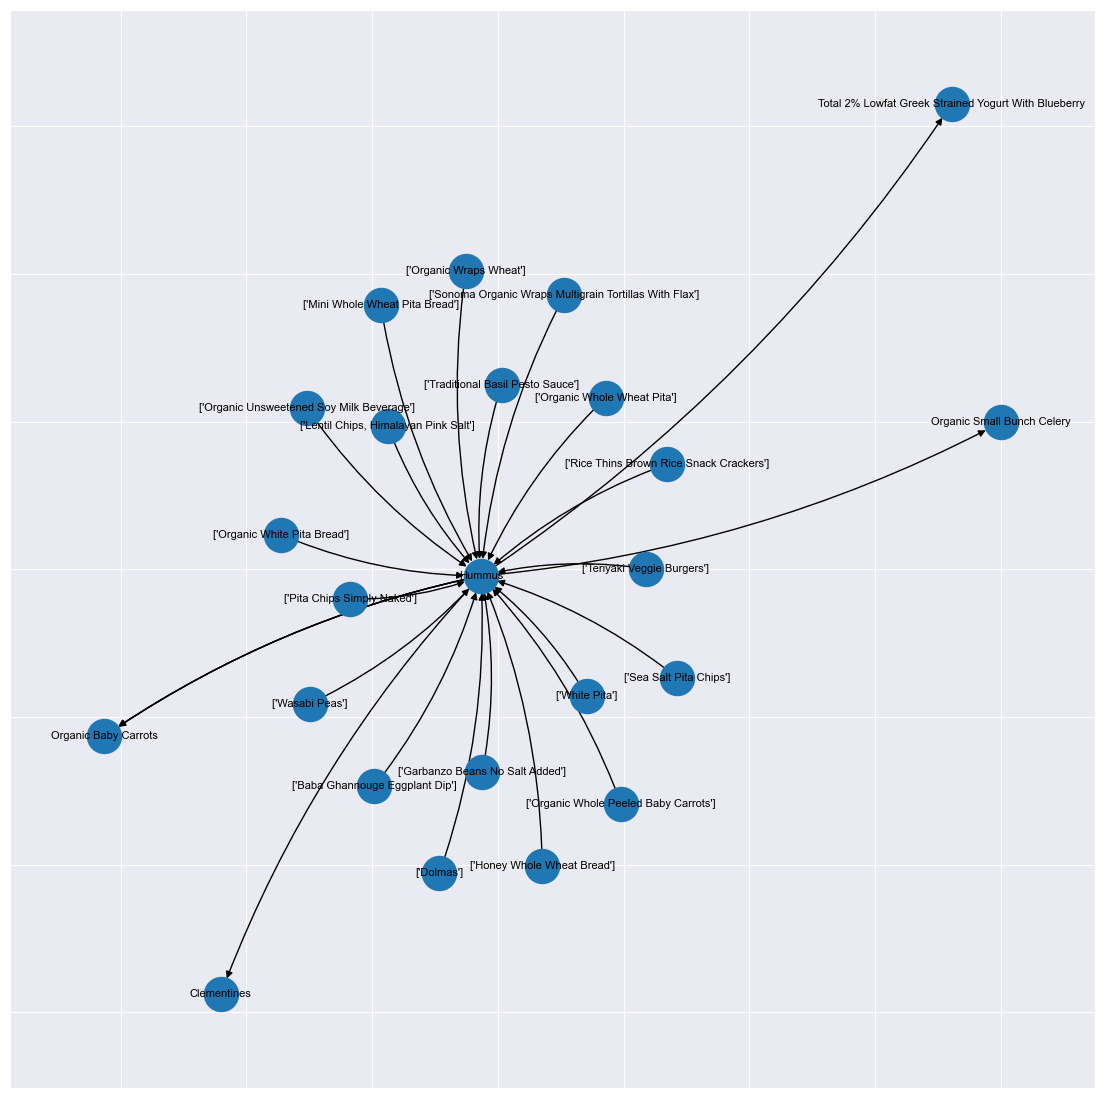

In [8]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.
graph_rules_subset = nx.MultiDiGraph()
connections = []
for from_node, to_node in zip(df_rules_subset['antecedent_items'], df_rules_subset['consequent_item']):
    connections.append([from_node, to_node])
graph_rules_subset.add_edges_from(
    connections
)
# Then render the graph.
plt.figure(1,figsize=(14,14))
# apparently you can create spacing, which was annoying to not see
pos = nx.spring_layout(graph_rules_subset, k=0.5, seed=42) # k -> spacing scale desired
nx.draw_networkx(graph_rules_subset,
                 pos=pos,
                 arrows=True,
                 node_size=600,
                 font_size=8,
                 node_color="tab:blue",
                 font_color='black',
                 connectionstyle='arc3, rad=0.1'
                 )

What can you tell about people who buy hummus?

Those who buy Hummus seem to also trend towards buying "Pita Chips Simply Naked", and also "Teriyaki Veggie Burgers"? somehow. The others are basically other pita chips or chips, including Sea Salt Pita Chips, White Pita, etc. 

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [11]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}
df_rules_clear = df_rules[df_rules['antecedent_items'].apply(len) == 1]
df_rules_clear.loc[:, 'antecedent_items'] = df_rules_clear['antecedent_items'].apply(str) # fixed df warning of modifying actual DF
df_rules_predict = df_rules_clear.copy()
df_rules_predict[
    df_rules_predict['antecedent_items'].str.contains('Orange Bell Pepper', regex=False) # Checking Orange Bell Pepper will also check Organic Red Bell Pepper :D
         ] \
        .sort_values('lift', ascending=False) \
        .head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
364344,Organic Bell Pepper,3346083,2449,11005,24331,['Organic Orange Bell Pepper'],0.000732,0.222535,30.603809
370169,Yellow Bell Pepper,3346083,7520,41052,26625,['Orange Bell Pepper'],0.002247,0.183182,23.021341
396572,Organic Red Bell Pepper,3346083,2259,11005,59878,['Organic Orange Bell Pepper'],0.000675,0.205270,11.470850
449846,Red Peppers,3346083,5529,41052,58185,['Orange Bell Pepper'],0.001652,0.134683,7.745295
514125,Green Bell Pepper,3346083,1169,11005,58005,['Organic Orange Bell Pepper'],0.000349,0.106224,6.127675
531201,Green Bell Pepper,3346083,4144,41052,58005,['Orange Bell Pepper'],0.001238,0.100945,5.823133
572390,Organic Cucumber,3346083,1458,11005,85005,['Organic Orange Bell Pepper'],0.000436,0.132485,5.215065
661896,Organic Grape Tomatoes,3346083,1222,11005,88078,['Organic Orange Bell Pepper'],0.000365,0.111040,4.218426
667831,Organic Zucchini,3346083,1498,11005,109412,['Organic Orange Bell Pepper'],0.000448,0.136120,4.162876
683930,Organic Raspberries,3346083,1885,11005,142603,['Organic Orange Bell Pepper'],0.000563,0.171286,4.019105


Seems that the higher lifts are Organic Bell Pepper, Yellow Bell Pepper, and Organic Red Bell Pepper being the consequent items following Organic Orange Bell Peppers and Orange Bell Peppers.
Anything not pepper related in consequent items would be Cucumbers, Grape Tomatoes, Zucchini, Raspberries, and others

## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.